## 1. AB testing with cookie cats
<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> Cookie Cats is a popular mobile puzzle game developed by Tactile Entertainment. The game follows a "connect three" style where players must match tiles of the same colour to clear the board and advance through levels. The game also features singing cats, adding a unique and entertaining twist.

As players progress, they encounter gates that temporarily halt their progress, requiring them to either wait or make an in-app purchase to continue. These gates not only encourage in-app purchases but also provide players with a forced break, potentially enhancing and prolonging their enjoyment of the game.

This project focuses on an AB test conducted to determine the optimal placement of these gates. Originally, the first gate was positioned at level 30, but in this experiment, the gate was moved to level 40 for a subset of players. The goal of this analysis is to assess the impact of this change on player retention, a critical metric for the game's success.

In [8]:
import pandas as pd

df =pd.read_csv('datasets/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. The AB-test data
<p>The data  is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [9]:
print(df['version'].value_counts()/df['version'].count()*100)



gate_40    50.437415
gate_30    49.562585
Name: version, dtype: float64


## 3. The distribution of game rounds


Text(0,0.5,'userid.')

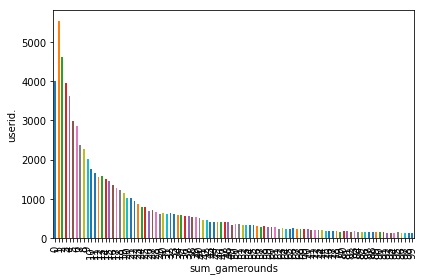

In [10]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(kind='bar')
ax.set_xlabel("sum_gamerounds")
ax.set_ylabel("userid.")

## 4. Overall 1-day retention
<p>The plot illustrates varying levels of player engagement, from those who install the game but never play, to those who play extensively in their first week. The goal is to increase player engagement, with a key metric being 1-day retention: the percentage of players who return to the game one day after installation. High 1-day retention is crucial for building a large, loyal player base.<p>

In [11]:
df['retention_1'].mean()

0.4452095044850259

## 5. 1-day retention by AB-group
<p>Examine 1-day retention differs between the two AB-groups.</p>

In [12]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## 6. Should we be confident in the difference?
<p>A slight decrease in 1-day retention is observed when the gate is moved to level 40 (44.2%) compared to the control group with the gate at level 30 (44.8%). Although this change is small, even minor shifts in retention can have a significant impact. While the data shows a difference, the question arises: how confident can we be that a gate at level 40 will perform worse in the future?

To assess the certainty of these retention numbers, bootstrapping will be used. This involves repeatedly re-sampling the dataset with replacement and calculating the 1-day retention for each sample. The variation in these bootstrapped retention rates will provide insight into the uncertainty of the retention estimates.</p>


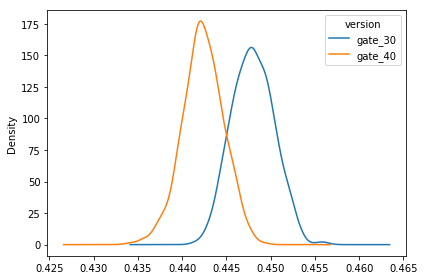

In [13]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='kde')

## 7. Zooming in on the difference
<p>The distributions above illustrate the bootstrap uncertainty regarding the underlying 1-day retention for the two AB groups. Visual inspection suggests a small difference between the groups. To better understand this, the focus now shifts to the difference in 1-day retention.<p>

<p>Note: In this notebook, the number of bootstrap replications is limited to 500 for quick calculations. In a production setting, it would be advisable to increase this number to a larger figure, such as 10,000, for more robust results.<p>

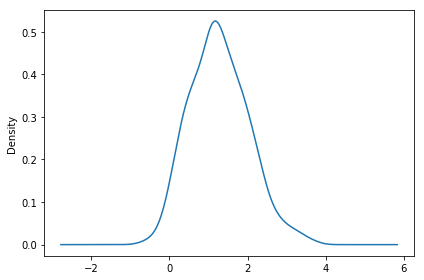

In [14]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = ((boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40']*100)

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='kde')

## 8. The probability of a difference

<p>The chart indicates that the most likely percentage difference in 1-day retention between the two groups is around 1% to 2%, with the majority of the distribution above 0%, favouring a gate at level 30. To quantify this, the probability that the difference is greater than 0% will be calculated</p>

In [15]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Pretty printing the probability
'{:.1%}'.format(prob)

# Pretty printing the probability
# ... YOUR CODE FOR TASK 8 ...

'97.4%'

## 9. 7-day retention by AB-group
<p>The bootstrap analysis suggests a high probability that 1-day retention is better when the gate is positioned at level 30. However, since players have only been playing for one day, many might not have reached level 30 yet, meaning the gate's impact may be minimal at this stage.

After a week of gameplay, more players are expected to have reached level 40. This makes it important to also examine 7-day retention: the percentage of players who return to the game a week after installation.<p>

In [16]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 10. Bootstrapping the difference again
<p>Similar to the 1-day retention analysis, the 7-day retention is observed to be slightly lower when the gate is positioned at level 40 (18.2%) compared to when it is at level 30 (19.0%). This difference is more pronounced than in the 1-day retention, likely because more players encounter the gate after a week of gameplay.</p>

</p>It is also noted that overall 7-day retention is lower than 1-day retention, which is expected, as fewer players typically return to play a game a week after installing it compared to the day after.</p>

'97.4%'

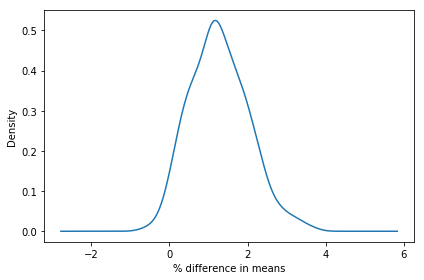

In [21]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d =pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100
    

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).mean()

# Pretty printing the probability
'{:.1%}'.format(prob)

## 11.  The conclusion
<p>The bootstrap analysis indicates that 7-day retention is significantly higher when the gate is set at level 30 compared to level 40. This suggests that to maintain high retention — both in the short-term (1-day) and medium-term (7-day) — it's advisable to keep the gate at level 30 rather than moving it to level 40. While other metrics, such as the number of game rounds played or in-game purchases, are also important, retention remains a critical metric. Without a strong player base, other performance indicators, like revenue, become less meaningful.

Retention is higher with an earlier gate due to the concept of hedonic adaptation. This theory suggests that continuous engagement in an activity can lead to diminishing enjoyment over time. By introducing a gate at an earlier level, players are given a break, which can prolong their enjoyment of the game. When the gate is moved to level 40, fewer players reach it, and those who do might already be experiencing diminishing enjoyment, making them more likely to stop playing.